# Understanding B-Cos Explanations
- first script focusing on printing explanations of images
- understanding different commands

In [1]:
import os
import random
import sys
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from PIL import Image
import pydicom
from sklearn.model_selection import KFold
from bcosconv2d import NormedConv2d
from torchvision.transforms import functional as TF

from torchvision.transforms import ToPILImage

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

model_path = r"C:\Users\Admin\Documents\MasterThesis\BestPerformingResNet50BCosResult\pneumonia_detection_model_bcos_trans_bestf1_1_24.pth"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.hub.list('B-cos/B-cos-v2')

# load a pretrained model
model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)    
num_features = model.layer4[-1].conv3.linear.out_channels
model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

# Load trained weights (optional)
model = model.to(device)

image_path = os.path.join(image_folder,"db7bce8f-978c-47b1-8b74-7640f7c3625e.dcm")
dicom = pydicom.dcmread(image_path)
image = Image.fromarray(dicom.pixel_array).convert("RGB")

img_new = model.transform(image)
img_new = img_new[None]
img_new = img_new.to(device)

model.eval()
logits = model(img_new)
expl = model.explain(img_new)
print(expl['contribution_map'])
print(expl['contribution_map'].min())
print(expl['contribution_map'].max())


print(expl.keys())
print(logits)

Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


tensor([[[ 8.8028e-03,  1.2075e-02,  1.3275e-02,  ...,  1.5000e-05,
           1.8113e-05,  6.8094e-06],
         [ 9.5310e-03,  1.2780e-02,  1.0647e-02,  ...,  1.1201e-05,
           2.2051e-05,  9.5416e-06],
         [ 1.2776e-02,  9.4194e-03,  4.3671e-03,  ...,  4.4907e-06,
           2.1765e-05,  1.8318e-05],
         ...,
         [-1.2808e-05, -3.0102e-06, -1.7174e-06,  ..., -9.4703e-06,
          -1.1189e-05, -1.1258e-05],
         [-1.7311e-05, -1.4454e-05, -1.3170e-05,  ..., -1.1863e-05,
          -1.0585e-05, -1.0589e-05],
         [-7.0272e-06, -8.1357e-06, -1.1108e-05,  ..., -1.1060e-05,
          -1.0408e-05, -1.0160e-05]]], device='cuda:0', grad_fn=<SumBackward1>)
tensor(-0.0008, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0215, device='cuda:0', grad_fn=<MaxBackward1>)
dict_keys(['prediction', 'explained_class_idx', 'dynamic_linear_weights', 'contribution_map', 'explanation'])
tensor([[-5.7917,  6.1621]], device='cuda:0', grad_fn=<AddBackward0>)


# Evaluate whole validation set

In [2]:
old_params = 0
old_image = 0
old_img = 0
contribution_map = 0

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_key = k[7:] 
            new_state_dict[new_key] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


In [4]:
import os
import random
import sys
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from PIL import Image
import pydicom
from sklearn.model_selection import KFold
from bcosconv2d import NormedConv2d
from torchvision.transforms import functional as TF
from torchvision.transforms import ToPILImage

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

model_path = r"C:\Users\Admin\Documents\MasterThesis\BestPerformingResNet50BCosResult\pneumonia_detection_model_bcos_trans_bestf1_1_24.pth"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced.pkl"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
data = pd.read_csv(csv_path)

splits = 0
with open(splits_path, 'rb') as f:
    splits = pickle.load(f)
    
first_split = splits[0]
val_fifth_split = first_split[1]
print(val_fifth_split)

# LOAD MODEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)    
model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
state_dict = torch.load(model_path, map_location=device)
#fixed_dict = remove_module_prefix(state_dict)
model.load_state_dict(state_dict)
model = model.to(device)






[    4     9    12 ... 30214 30221 30223]


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Prediction: 0


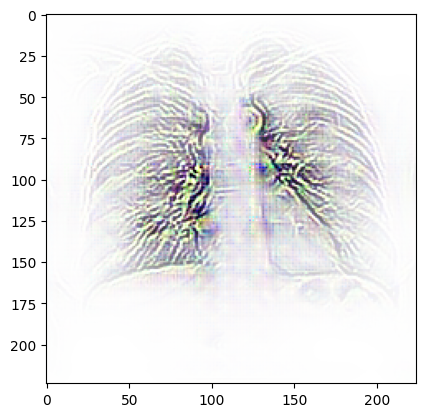

Prediction: 0


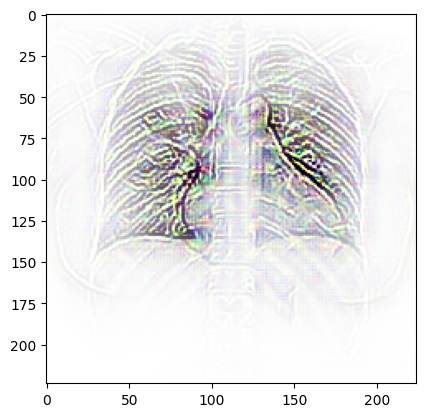

Prediction: 0


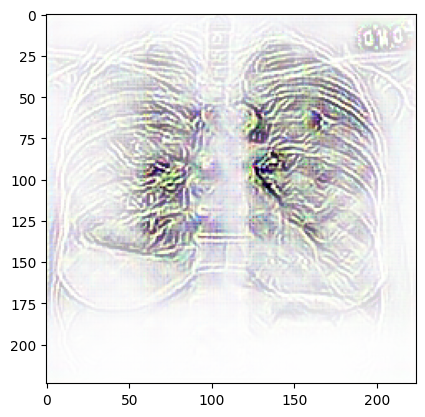

Prediction: 0


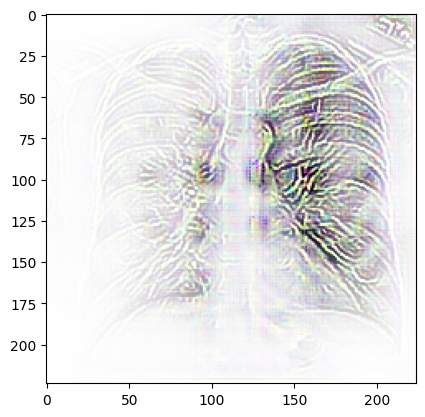

Prediction: 0


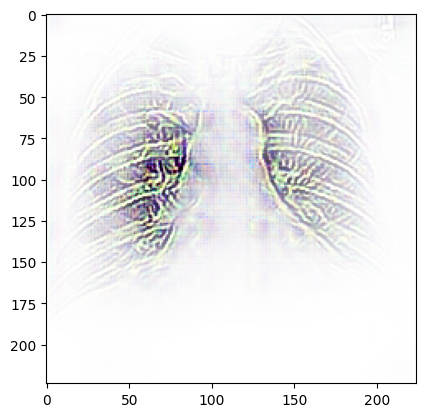

In [6]:
model.eval()

count = 0
for index in val_fifth_split[:10]:
    count +=1
    row = data.iloc[index]
    image_path = os.path.join(image_folder, f"{row['patientId']}.dcm")
    label = row['Target']
        
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    
    image = Image.fromarray(image).convert("RGB")
    tensor_image = TF.to_tensor(image)
    img_new = model.transform(image)
    img_new = img_new[None]
    img_new = img_new.to(device)

    
    expl = model.explain(img_new)    
    #print(expl)
    #print(expl["contribution_map"] == contribution_map)
    #contribution_map = expl["contribution_map"]
    prediction = expl["prediction"]
    if (prediction == 0):
        print("Prediction:", expl["prediction"])
        plt.imshow(expl["explanation"])
        plt.show()
    
    del(img_new)
    torch.cuda.empty_cache()


In [ ]:
model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
